In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scanpy as sc
import os
import pertpy as pt

from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
print (date)

path = './'

2024-05-08


## Code for generating Figures 3B-G
* Loading in preprocessed and concatenated data from the notebook "data_processing-clustering.ipynb"

In [2]:
concat_adata = sc.read_h5ad('concat_adata.h5ad')

order = ['U-mRNA', 'm1Ψ-mRNA', 'GPC', 'Empty LNP']
colordict = {'U-mRNA': 'blue', 'm1Ψ-mRNA': 'red', 'GPC': 'lightgreen', 'Empty LNP': 'black'}

In [3]:
concat_adata

AnnData object with n_obs × n_vars = 42810 × 1466
    obs: 'Isotype', 'Repeat', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Sample', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Sample_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

### Figure 3B

c:\Users\perry\anaconda3\envs\sccode\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\perry\anaconda3\envs\sccode\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\perry\anaconda3\envs\sccode\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\p

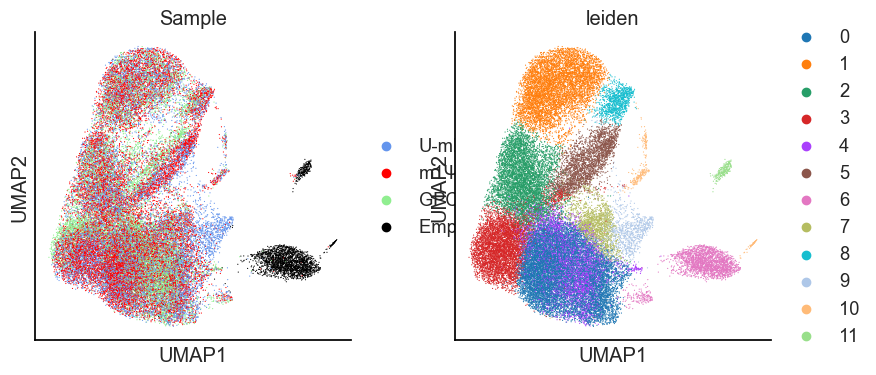

In [ ]:
sns.set(rc = {'figure.figsize':(4,4),  'axes.edgecolor': 'black', 'axes.spines.right': False,
          'axes.spines.top': False, 'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale = 1.2)

sc.pl.umap(concat_adata, color= ['Sample', 'leiden']) #, palette=colordict) # , save='_sample_allisotypes_23-03-03.svg')

### Leiden composition

In [6]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    concat_adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="leiden", # Cluster assignments
    sample_identifier="Repeat",    # Mouse repeat within each treatment group
    covariate_obs=["Sample"])     # Treatmant group (U-mRNA, m1Ψ-mRNA, GPC, Empty LNP)

sccoda_data

MuData object with n_obs × n_vars = 42826 × 1478
  2 modalities
    rna:	42810 x 1466
      obs:	'Isotype', 'Repeat', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Sample', 'leiden', 'scCODA_sample_id'
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'Sample_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    coda:	16 x 12
      obs:	'Sample', 'Repeat'
      var:	'n_cells'

### Figure 3C

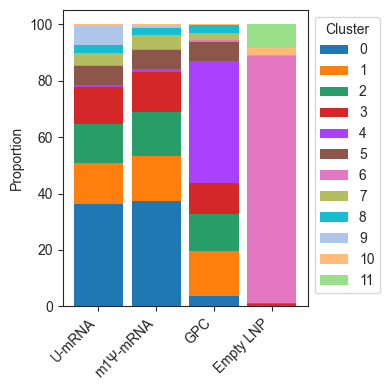

In [13]:
from matplotlib.colors import ListedColormap

palette = sns.color_palette("tab20", n_colors=123123)

# Convert the seaborn palette to a matplotlib colormap
cmap = ListedColormap(sc.pl.palettes.default_20)

pt.pl.coda.stacked_barplot(sccoda_data, modality_key="coda", feature_name="Sample", figsize=(4, 4), cmap=cmap)

plt.legend(title='Cluster', bbox_to_anchor=(1,1))
plt.title('')
plt.tight_layout()

plt.savefig('cluster_proportions_sccoda.svg')

In [16]:
sccoda_data.mod["U-P"] = sccoda_data["coda"][
    sccoda_data["coda"].obs["Sample"].isin(["m1Ψ-mRNA", "U-mRNA"])].copy() # Create object to compare these 2 groups

In [17]:
# Running NUTS model for estimating compositional changes. Run time ~1 minute on laptop with i9 processor
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="U-P",
    formula="C(Sample, Treatment('m1Ψ-mRNA'))",
    reference_cell_type="1") # Using largest cluster as a reference (multiple references were tested with robust results)
sccoda_model.run_nuts(sccoda_data, modality_key="U-P")
sccoda_model.summary(sccoda_data, modality_key="U-P", est_fdr=0.05) # Using 5% false discovery rate

Zero counts encountered in data! Added a pseudocount of 0.5.

sample: 100%|██████████| 11000/11000 [00:52<00:00, 211.12it/s, 127 steps of size 1.71e-02. acc. prob=0.72]


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────┐
│ Name                                      │ Value                                                               │
├───────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ Data                                      │ Data: 8 samples, 12 cell types                                      │
│ Reference cell type                       │ 1                                                                   │
│ Formula                                   │ C(Sample, Treatment('m1Ψ-mRNA'))                                    │
└───────────────────────────────────────────┴─────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            Final Parameter  Expected Sample                                                                     │
│ Cell Type                                                                                                       │
│ 0               5.452          1407.478                                                                         │
│ 1               4.569           582.049                                                                         │
│ 2               4.532           560.907                                                                         │
│ 3               4.467           525.608                                                                         │
│ 4               1.730            34.041                                                                         │
│ 5               3.740           254.056                                                                         │
│ 6               0.997            16.355                                                                         │
│ 7               3.392           179.389                                                                         │
│ 8               2.803            99.540                                                                         │
│ 9               0.865            14.333                                                                         │
│ 10              1.578            29.241                                                                         │
│ 11             -0.442             3.879                                                                         │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                       Final Parameter  Expected Sample  log2-fold change        │
│ Covariate                                  Cell Type                                                            │
│ C(Sample, Treatment('m1Ψ-mRNA'))[T.U-mRNA] 0              0.000           1330.116           -0.082             │
│                                            1              0.000            550.057           -0.082             │
│                                            2              0.000            530.077           -0.082             │
│                                            3              0.000            496.718           -0.082             │
│                                            4              0.000             32.170           -0.082             │
│                                            5              0.000            240.092           -0.082             │
│                                            6              0.000             15.456           -0.082             │
│                                            7              0.000            169.529           -0.082             │
│                                            8              0.000             94.068           -0.082             │
│                                            9              2.775            217.294            3.922             │
│                                            10             0.000             27.633           -0.082             │
│                                            11             0.000              3.666           -0.082             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

### Figure 3D

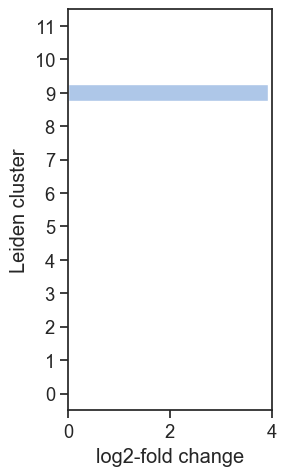

In [18]:
sns.set(rc = {'figure.figsize':(3.1,5),  'axes.edgecolor': 'black', 'axes.spines.right': False,
          'axes.spines.top': False, 'axes.facecolor':'white', 'figure.facecolor':'white', 'xtick.bottom':True, 'ytick.left':True}, font_scale = 1.2, palette=sc.pl.palettes.default_20)
sns.set_style('ticks')

sccoda_data['U-P'].varm["effect_df_C(Sample, Treatment('m1Ψ-mRNA'))[T.U-mRNA]"]['log2-fold change'].plot.barh(color=sc.pl.palettes.default_20)

plt.xlim(0,4)

plt.xlabel('log2-fold change')
plt.ylabel('Leiden cluster')

plt.tight_layout()

plt.savefig('logfold_compositional_change.svg')

#### Figure 3E

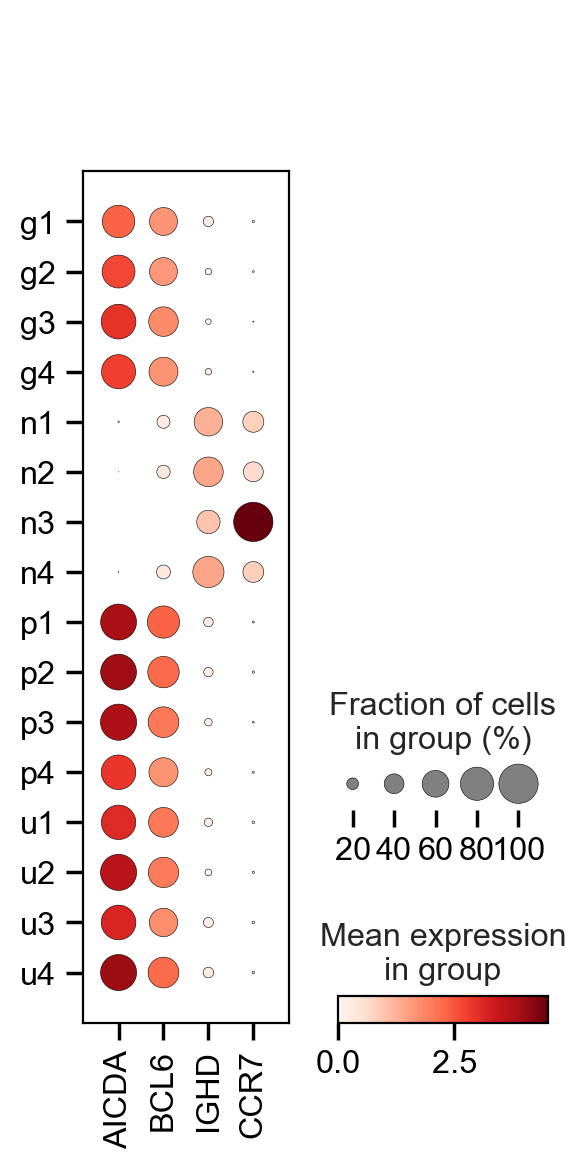

In [19]:
from matplotlib.pyplot import rc_context

sc.set_figure_params(dpi=100, figsize=(3,2))
sc.pl.dotplot(concat_adata, var_names=['AICDA', 'BCL6', 'IGHD','CCR7'], groupby='Repeat') #, save='GC_markers_24-03-11.svg')

### Figure 3G

In [21]:
# Used this reference set: https://www.gsea-msigdb.org/gsea/msigdb/cards/GSE38696_LIGHT_ZONE_VS_DARK_ZONE_BCELL_UP

plasma_markers = pd.read_csv('./GSE38696_LIGHT_ZONE_VS_DARK_ZONE_BCELL_UP.v2023.2.Hs.tsv', sep='\t')

plasma_markers = plasma_markers[plasma_markers['STANDARD_NAME'] ==  'GENE_SYMBOLS']['GSE38696_LIGHT_ZONE_VS_DARK_ZONE_BCELL_UP'].values
plasma_markers = plasma_markers[0].split(',')
# First 4 are B cell markers, then naive markers, then plasmablast markers
filter_markers = np.intersect1d(plasma_markers, concat_adata.to_df().columns)

sc.tl.score_genes(concat_adata,plasma_markers,score_name='DZ_LZ_score', use_raw=True)

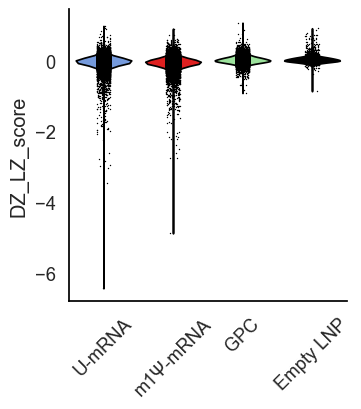

In [27]:
sc.pl.violin(concat_adata, keys=['DZ_LZ_score'], groupby='Sample', rotation=45) #, save='DZ_LZ_score.svg')

### Figure 3F

In [30]:
activation_markers = ['CD27', 'TNFRSF13B','AICDA', 'CD79B','IGHM','CD38', 'CD69', 'CD80', 'CD86', 'CD69', 'CD40', 'SELL', 'CD69', 'CD83', 'TXNIP', 'XBP1',  'PRDM1', 'TLR7']

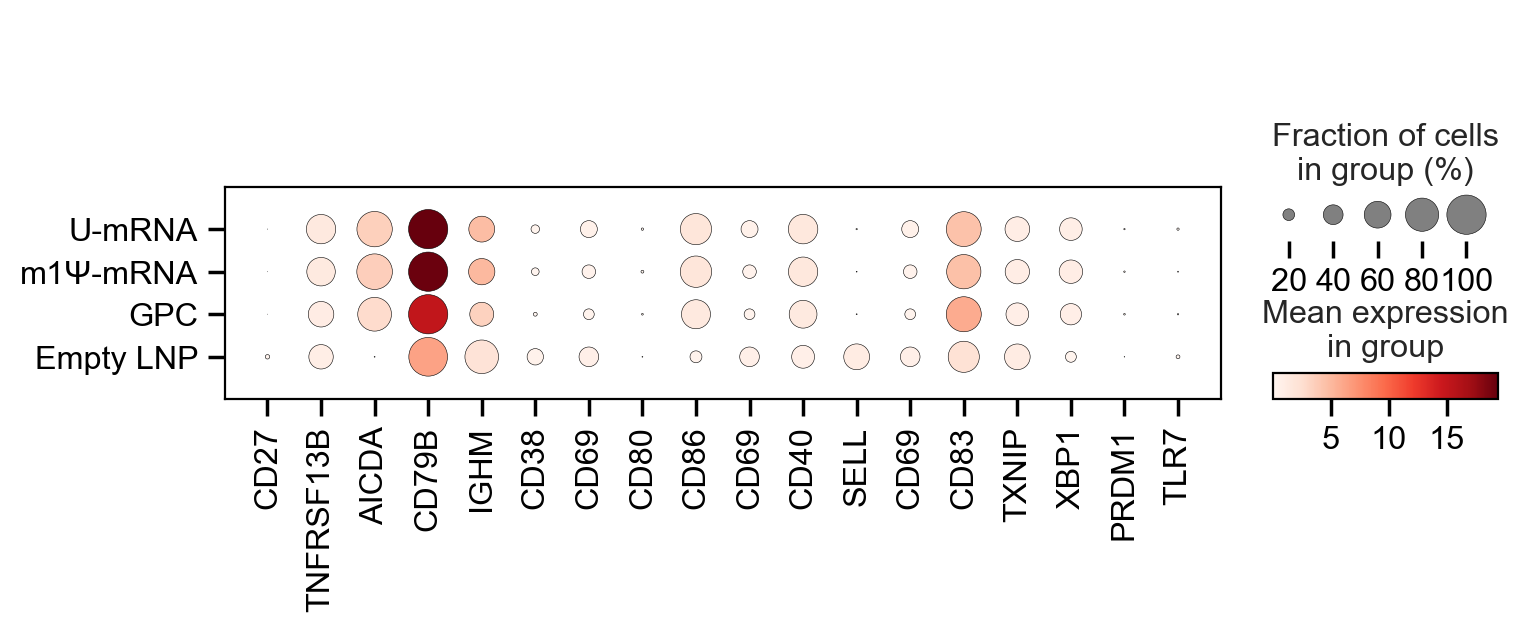

In [31]:
# All isotypes
sc.pl.dotplot(concat_adata, groupby='Sample', var_names=activation_markers, use_raw=True) #, save='_activation_markers_sample.svg')

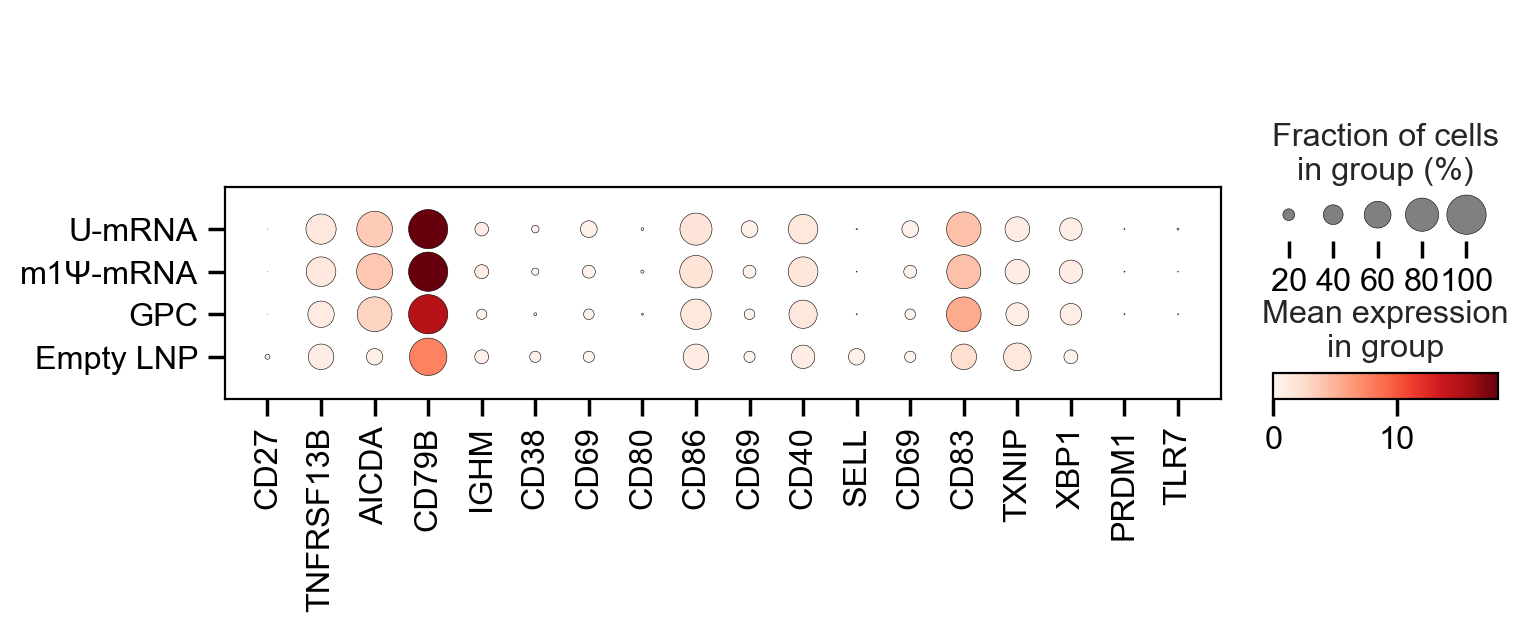

In [32]:
IgG_adata = concat_adata[concat_adata.obs['Isotype'].isin(['IGHG1', 'IGHG2C', 'IGHG2B', 'IGHG3'])]

sc.pl.dotplot(IgG_adata, groupby='Sample', var_names=activation_markers, use_raw=True) #, save='_activation_markers_IgG_sample.svg') 

### Looking at IgG only

In [363]:
vdj_df = vdj_df[vdj_df['C_CALL.H'] != 'IGHM']
vdj_df = vdj_df[vdj_df['C_CALL.H'] != 'IGHD']
vdj_df = vdj_df[vdj_df['C_CALL.H'] != 'IGHE']
vdj_df = vdj_df[vdj_df['C_CALL.H'] != 'IGHM']
vdj_df = vdj_df[vdj_df['C_CALL.H'] != 'IGHA']

vdj_df['C_CALL.H'].value_counts()

IGHG1     13735
IGHG2C     5489
IGHG2B     2601
IGHG3       443
Name: C_CALL.H, dtype: int64

In [364]:
IgG_adata = concat_adata[vdj_df.index]

In [308]:
IgG_adata

View of AnnData object with n_obs × n_vars = 22323 × 1466
    obs: 'Isotype', 'Repeat', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Sample', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'Sample_colors', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

### DGE by Sample in IgG

c:\Users\perry\anaconda3\envs\scanpy\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
c:\Users\perry\anaconda3\envs\scanpy\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\perry\anaconda3\envs\scanpy\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\perry\anaconda3\envs\scanpy\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\perry\anaconda3\envs\scanpy\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldcha

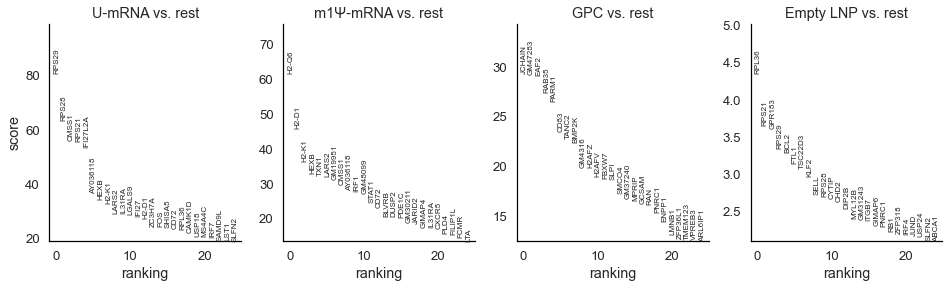

In [178]:
sc.tl.rank_genes_groups(IgG_adata, 'Sample', method='wilcoxon', use_raw=False)
sc.pl.rank_genes_groups(IgG_adata, n_genes=25, sharey=False)

In [180]:
dge_df

,m1Ψ-mRNA_n,m1Ψ-mRNA_s,m1Ψ-mRNA_p,m1Ψ-mRNA_l,U-mRNA_n,U-mRNA_s,U-mRNA_p,U-mRNA_l
0,H2-Q6,35.039268,1.665728e-266,3.637577,RPS29,68.707336,0.000000e+00,NaN
1,GM30211,17.589146,3.644731e-67,NaN,RPS28,56.936260,0.000000e+00,NaN
2,IRF1,16.143154,1.430923e-56,NaN,IFI27L2A,44.700748,0.000000e+00,NaN
3,TXN1,13.500192,1.345019e-39,0.877907,RPS21,41.125301,0.000000e+00,NaN
4,GM19951,10.485963,5.537472e-24,1.678324,RPL36,28.437695,1.690388e-175,NaN
...,...,...,...,...,...,...,...,...
1461,RPL36,-28.437695,1.690388e-175,NaN,GM19951,-10.485963,5.537472e-24,-1.678324
1462,RPS21,-41.125301,0.000000e+00,NaN,TXN1,-13.500192,1.345019e-39,-0.877907
1463,IFI27L2A,-44.700748,0.000000e+00,NaN,IRF1,-16.143154,1.430923e-56,NaN
1464,RPS28,-56.936260,0.000000e+00,NaN,GM30211,-17.589146,3.644731e-67,NaN


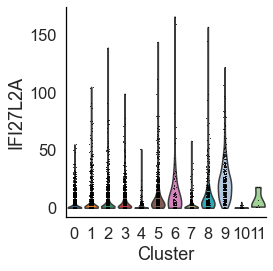

In [ ]:
sc.pl.violin(IgG_adata, groupby='leiden', keys=['IFI27L2A'], xlabel='Cluster') #, save='_leiden_IFI27L2A.svg')

### Enrichr

In [233]:
pg_adata = IgG_adata[IgG_adata.obs['Sample'] != 'Empty LNP']
pg_adata = pg_adata[pg_adata.obs['Sample'] != 'GPC']
pg_adata

View of AnnData object with n_obs × n_vars = 16325 × 1466
    obs: 'Isotype', 'Repeat', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Sample', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'Sample_colors', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

c:\Users\perry\anaconda3\envs\scanpy\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
c:\Users\perry\anaconda3\envs\scanpy\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\perry\anaconda3\envs\scanpy\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


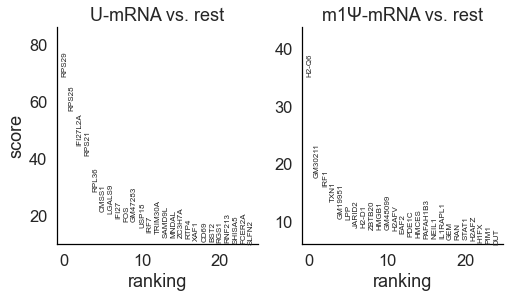

In [234]:
sc.tl.rank_genes_groups(pg_adata, 'Sample', method='wilcoxon', use_raw=False)
sc.pl.rank_genes_groups(pg_adata, n_genes=25, sharey=False)

c:\Users\perry\anaconda3\envs\scanpy\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


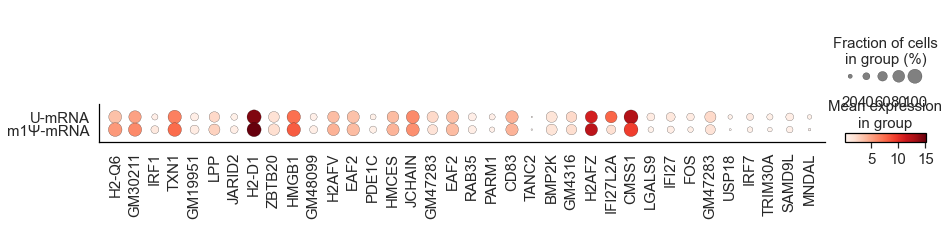

In [235]:
result = pg_adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

dge_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals_adj', 'logfoldchanges']})



p_genes = dge_df['m1Ψ-mRNA_n'].head(15)
# g_genes = dge_df['GPCAg_n'].head(10)
u_genes = dge_df['U-mRNA_n'].head(15)

dge_genes = np.concatenate([p_genes, g_genes, u_genes])
dge_genes = [i for i in dge_genes if 'RP' not in i]
sc.pl.dotplot(pg_adata, var_names = dge_genes, groupby='Sample')

In [ ]:
u_genes

['IFI27L2A',
 'CMSS1',
 'LGALS9',
 'IFI27',
 'FOS',
 'GM47283',
 'USP18',
 'IRF7',
 'TRIM30A',
 'SAMD9L',
 'MNDAL']

In [236]:
# sc.pl.dotplot(IgG_adata, var_names=u_genes[0:10], groupby='leiden', ylabel='Cluster') #, save='ugenes_dotplot.svg')

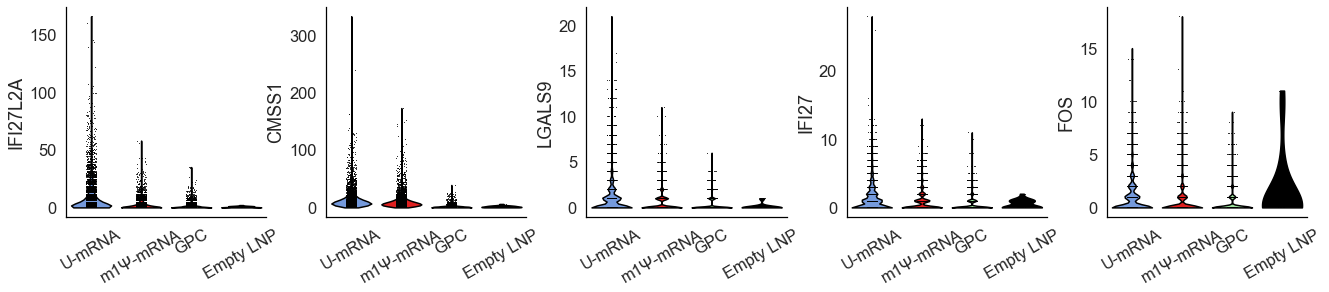

In [220]:
sns.set(rc = {'figure.figsize':(4,4),  'axes.edgecolor': 'black', 'axes.spines.right': False,
          'axes.spines.top': False, 'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale = 1.5)

u_genes = [i for i in u_genes if 'RP' not in i]
p_genes = [i for i in p_genes if 'RP' not in i]

sc.pl.violin(IgG_adata, groupby='Sample', keys=u_genes[0:5], rotation=30), # save='_u_genes_1-6.svg') # 
sc.pl.violin(IgG_adata, groupby='Sample', keys=u_genes[5:10], rotation=30), # save='_u_genes_1-6.svg') # 
sc.pl.violin(IgG_adata, groupby='Sample', keys=u_genes[10:15], rotation=30), # save='_u_genes_1-6.svg') # 

### DGE for Cluster 9

c:\Users\perry\anaconda3\envs\scanpy\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\perry\anaconda3\envs\scanpy\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


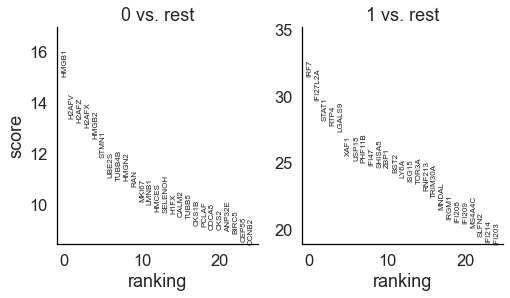

In [251]:
sc.tl.rank_genes_groups(pg_adata, 'Cluster 9', method='wilcoxon', use_raw=False)
sc.pl.rank_genes_groups(pg_adata, n_genes=25, sharey=False)

In [252]:
# get deg result
result = pg_adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

In [254]:
degs.head(3)

,0_names,0_scores,0_pvals,0_pvals_adj,0_logfoldchanges,1_names,1_scores,1_pvals,1_pvals_adj,1_logfoldchanges
0,HMGB1,15.006396,6.667307e-51,2.645299e-49,NaN,IRF7,31.447382,4.558226e-217,6.691476e-214,11.205507
1,H2AFV,13.392637,6.676705e-41,2.227592e-39,-3.859810,IFI27L2A,29.666782,2.060620e-193,1.512495e-190,NaN
2,H2AFZ,13.216969,7.002922e-40,2.234846e-38,-7.720423,STAT1,28.152822,2.213166e-174,1.082976e-171,4.930328


In [256]:
# subset up or down regulated genes
degs_sig = degs[degs['1_pvals_adj'] < 0.05]
degs_up = degs_sig[degs_sig['1_logfoldchanges'] > 0]
degs_dw = degs_sig[degs_sig['1_logfoldchanges'] < 0]

In [258]:
# Enricr API
enr_up = gp.enrichr(degs_up['1_names'],
                    gene_sets='GO_Biological_Process_2021',
                    outdir=None)

enr_dw = gp.enrichr(degs_dw['1_names'],
                    gene_sets='GO_Biological_Process_2021',
                    outdir=None)

### Figure S4D

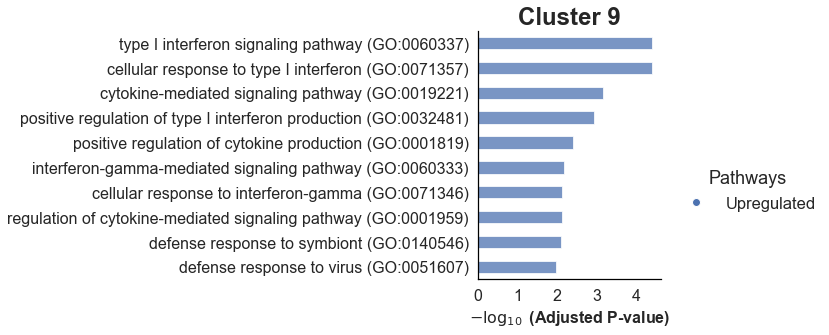

In [277]:
enr_up.res2d['Pathways'] = "Upregulated"
enr_dw.res2d['UP_DW'] = "DOWN"
enr_res = pd.concat([enr_up.res2d.head(10)])

gp.barplot(enr_res, figsize=(12,5),
                group ='Pathways',
                title ="Cluster 9",
                color = ['b'])
p = plt.gcf()
p.tight_layout()
p.savefig('cluster9_upregulated_barplot.png')